<a href="https://colab.research.google.com/github/murilo-henrique060/matematica-computacional/blob/main/Atividade%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [581]:
from typing import List, Tuple

from IPython.display import Image

import hashlib
import numpy as np
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [582]:
class Plot():
  def __init__(self, figsize : Tuple[int, int] = (6, 6), axis : Tuple[int, int, int, int] = (-5, 5, -5, 5), title=None):
    """
    Initializes a Plot object

    Args:
        figsize (int, int): Dimentions of the image generated by the plot
        axis (int, int, int, int): Horizontal and Vertical intervals that will be shown in the plot

    Returns:
        Plot: A plot object
    """
    self.title = title
    self.ani_filename = hashlib.md5((title if title is not None else 'plot').encode('utf-8')).hexdigest() + '.gif'
    self.fig, self.ax = plt.subplots(figsize=figsize)

    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)

    plt.axis(axis)
    plt.xticks(range(int(axis[0]), int(axis[1])+1))
    plt.yticks(range(int(axis[2]), int(axis[3])+1))

  def show(self):
    plt.show()

  def animate(self, update, frames=100, blit=True, interval=50):
    plt.close()
    self.ani = animation.FuncAnimation(self.fig, update, frames=frames, blit=blit, interval=interval)
    self.ani.save(self.ani_filename, writer="ffmpeg", fps=10)
    return Image(self.ani_filename)

In [583]:
class PlotObject():
  def __init__(self, plot: Plot, data=[], *args, **kwargs):
    """
    Initializes a PlotObject

    Args:
      plot (Plot): Plot that the object will be draw

    Returns:
      PlotObject: A PlotObject instance
    """
    self.plot = plot
    self.line, = plot.ax.plot([], [], *args, **kwargs)
    self._data = PlotData(self)
    self.data = data

  @property
  def data(self):
    return self._data

  @data.setter
  def data(self, value):
    if len(value) == 0:
      self.line.set_data([], [])
    else:
      x, y = zip(*value)
      self.line.set_data(x, y)


In [584]:
class PlotData():
  def __init__(self, obj):
    self._obj = obj

  def append(self, value):
    data = self._obj.line.get_data()
    data[0] = np.append(data[0], value[0])
    data[1] = np.append(data[1], value[1])

  def pop(self, index=-1):
    data = self._obj.line.get_data()
    data[0] = np.delete(data[0], index)
    data[1] = np.delete(data[1], index)

  def __getitem__(self, index):
    if isinstance(index, int):
      data = self._obj.line.get_xdata()
      if 0 <= index <= len(data):
        return PlotDataPoint(self, index)
      else:
        raise IndexError
    else:
      raise TypeError

  def __setitem__(self, index, value):
    data = self._obj.line.get_data()
    if 0 <= index <= len(data[0]):
      data[0][index] = value[0]
      data[1][index] = value[1]
    else:
      raise IndexError


In [585]:
class PlotDataPoint():
  def __init__(self, data_obj, index=None):
    if index is None:
      index = 0

    self._data_obj = data_obj
    self._index = index

  def __str__(self):
    return f"({self.x}, {self.y})"

  @property
  def x(self):
    return self[0]

  @x.setter
  def x(self, value):
    self[0] = value

  @property
  def y(self):
    return self[1]

  @y.setter
  def y(self, value):
    self[1] = value

  def __getitem__(self, index):
    if isinstance(index, int):
      if 0 <= index <= 1:
        data = self._data_obj._obj.line.get_data()
        return data[index][self._index]
      else:
        raise IndexError
    else:
      raise TypeError("Invalid index type")

  def __setitem__(self, index, value):
    if isinstance(index, int):
      match index:
        case 0:
          xdata = list(self._data_obj._obj.line.get_xdata())
          xdata[self._index] = value
          self._data_obj._obj.line.set_xdata(xdata)
        case 1:
          ydata = list(self._data_obj._obj.line.get_ydata())
          ydata[self._index] = value
          self._data_obj._obj.line.set_ydata(ydata)
        case _:
          raise IndexError
    else:
      raise TypeError("Invalid index type")



In [586]:
class Point(PlotObject):
  @staticmethod
  def points(plot, points : List[Tuple[float, float]], **kwargs):
    return list(map(lambda point: Point(plot, point, **kwargs), points))

  def __init__(self, plot, pos: Tuple[float, float], color='green', marker='o', **kwargs):
    super().__init__(plot, [pos], color=color, marker=marker, **kwargs)

  @property
  def pos(self):
    return self.data[0]

In [587]:
class Path(PlotObject):
  def __init__(self, plot: Plot, points: List[Tuple[int, int]], color='blue', **kwargs):
    super().__init__(plot, points, color=color, **kwargs)

  @property
  def points(self):
    return self.data

In [588]:
class FunctionPath(Path):
  def __init__(self, plot, function, samples=None, **kwargs):
    if samples is None:
      samples = 10 * int(plot.fig.get_figwidth())

    self._samples = samples
    self._function = function

    super().__init__(plot, [], **kwargs)
    self._update_path()

  @property
  def function(self):
    return self._function

  @function.setter
  def function(self, value):
    self._function = value
    self._update_path()

  @property
  def samples(self):
    return self._samples

  @samples.setter
  def samples(self, value):
    self._samples = value
    self._update_path()

  def _update_path(self):
    x_axis = self.plot.ax.get_xlim()
    points = [(x, self.function(x)) for x in np.linspace(x_axis[0], x_axis[1], self._samples, endpoint=True)]
    self.data = points

In [589]:
class LineFunctionPath(FunctionPath):
  def __init__(self, plot, function, **kwargs):
    super().__init__(plot, function, 2)

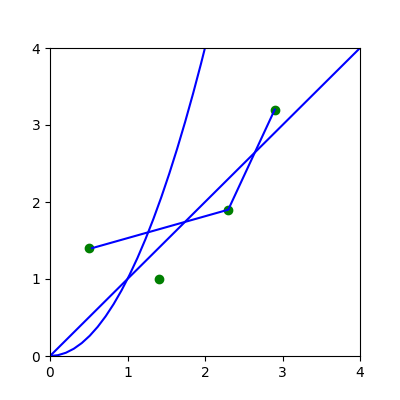

In [590]:
DATA = [
  (0.5, 1.4),
  (2.3, 1.9),
  (2.9, 3.2)
]

plot = Plot(figsize=(4,4), axis=(0, 4, 0, 4))
p = Point(plot, (1, 1))
Point.points(plot, DATA)
path = Path(plot, DATA)
function = FunctionPath(plot, lambda x: x**2)
line = LineFunctionPath(plot, lambda x: x + 1)

# plot.show()

def update(frames):
  p.pos.x += 0.1
  path.points[0].x += 0.01
  function.function = lambda x: (x - frames * 0.02) ** 2
  line.function = lambda x: x + frames * 0.02
  return ()

plot.animate(update)